In [1]:
import pandas as pd
import soundfile
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
#Extract features from soundfile
def extract_feature(file_name, **kwargs):
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
        result=np.hstack((result, mel))
    return result

In [3]:
#Emotions available in RAVDESS Dataset
emotions={
  '01':'NEUTRAL',
  '02':'CALM',
  '03':'HAPPY',
  '04':'SAD',
  '05':'ANGRY',
  '06':'FEARFUL',
  '07':'DISGUST',
  '08':'SURPRISED'
}
#Emotions we want to observe
observed_emotions=['NEUTRAL', 'HAPPY', 'FEARFUL', 'DISGUST']

In [4]:
#Loading the data
def load_data(test_size=0.25):
    x,y=[],[]
    answer = 0
    for file in glob.glob(r'E:\\CODE\\SpeechEmotionRecogniser\\Dataset\\*.wav'):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            answer += 1
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append([emotion,file_name])
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [5]:
# Splitting the dataset

x_train,x_test,y_trai,y_tes=load_data(test_size=0.25)
print(np.shape(x_train),np.shape(x_test), np.shape(y_trai),np.shape(y_tes))

# Mapping of testing data(predicted emotions) with corresponding filenames
y_test_map = np.array(y_tes).T
y_test = y_test_map[0]
test_filename = y_test_map[1]
y_train_map = np.array(y_trai).T
y_train = y_train_map[0]
train_filename = y_train_map[1]
print(np.shape(y_train),np.shape(y_test))

(504, 180) (168, 180) (504, 2) (168, 2)
(504,) (168,)


In [6]:
# Get the number of features extacted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


In [7]:
# Initialise MLPClassifier
model_params = {
    'alpha': 0.01,
    'batch_size': 200,
    'epsilon': 1e-08, 
    'hidden_layer_sizes': (600,), 
    'learning_rate': 'adaptive', 
    'max_iter': 500, 
}
model = MLPClassifier(**model_params)

#Train the model
print("Training the model...")
model.fit(x_train, y_train)

#Predict values for test set
y_pred = model.predict(x_test)

#Calculate accuracy
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))

Training the model...
Accuracy: 75.60%


In [9]:
Pkl_Filename = "Speech_Emotion_Detection_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model, file)

In [11]:
# Load model from file
with open(Pkl_Filename, 'rb') as file:  
    Speech_Emotion_Detection_Model = pickle.load(file)

Speech_Emotion_Detection_Model

MLPClassifier(alpha=0.01, batch_size=200, hidden_layer_sizes=(600,),
              learning_rate='adaptive', max_iter=500)

In [12]:
#Predict values for test set using saved model
y_pred = Speech_Emotion_Detection_Model.predict(x_test)

In [13]:
y_pred1 = pd.DataFrame(y_pred, columns=['predictions'])
y_pred1['file_names'] = test_filename
#print(y_pred1)
y_pred1.to_csv('Final_Predictions.csv')
y_pred1[:]

predictions                file_names
0         HAPPY  03-01-03-01-01-02-22.wav
1       FEARFUL  03-01-07-01-02-02-23.wav
2       DISGUST  03-01-07-02-01-02-05.wav
3       FEARFUL  03-01-06-01-01-02-11.wav
4       FEARFUL  03-01-06-02-02-02-16.wav
..          ...                       ...
163       HAPPY  03-01-03-02-02-02-13.wav
164     FEARFUL  03-01-06-02-02-02-09.wav
165     DISGUST  03-01-07-01-01-01-19.wav
166     DISGUST  03-01-01-01-01-01-07.wav
167     DISGUST  03-01-01-01-01-01-14.wav

[168 rows x 2 columns]

In [14]:
#To get Classification Report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

     DISGUST       0.71      0.78      0.75        51
     FEARFUL       0.76      0.78      0.77        40
       HAPPY       0.78      0.80      0.79        44
     NEUTRAL       0.81      0.64      0.71        33

    accuracy                           0.76       168
   macro avg       0.76      0.75      0.75       168
weighted avg       0.76      0.76      0.76       168



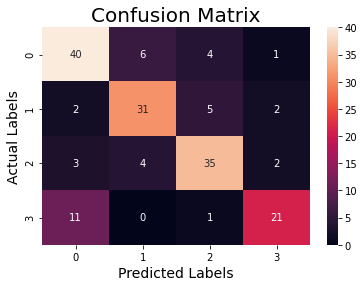

In [15]:
# To draw confusion matrix
cm=confusion_matrix(y_test,y_pred)
df_cm=pd.DataFrame(cm)
sns.heatmap(df_cm,annot=True,fmt='')
plt.title("Confusion Matrix", size=20)
plt.xlabel("Predicted Labels", size=14)
plt.ylabel("Actual Labels", size=14)
plt.savefig("Confusion_Matrix.png")
plt.show()

In [ ]:
import pyaudio
import wave

CHUNK = 1024 
FORMAT = pyaudio.paInt16 #paInt8
CHANNELS = 2 
RATE = 44100 #sample rate
RECORD_SECONDS = 4
WAVE_OUTPUT_FILENAME = "live_test.wav"

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK) #buffer

print("* recording")

frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data) # 2 bytes(16 bits) per channel

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

# Load the audio file
data, sampling_rate = librosa.load('live_test.wav', sr=None)

plt.figure(figsize=(12, 4))
librosa.display.waveshow(data, sr=sampling_rate)

In [ ]:
# Generate the Spectrogram
X = librosa.stft(data)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(12, 5))
librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')
plt.colorbar()